# 07. Data Subsetting and Transformation Services in the Cloud

## Using the Harmony-Py library to access customized data from NASA Earthdata 

---

### Timing:
- Exercise: 40 minutes

---

## Summary

We have already explored direct access to the NASA EOSDIS archive in the cloud via the Amazon Simple Storage Service (S3) by using the Common Metadata Repository (CMR) to search for granule locations. In addition to directly accessing the files archived and distributed by each of the NASA DAACs, many datasets also support services that allow us to customize the data via subsetting, reformatting, reprojection, and other transformations. 

This tutorial demonstrates how to find, request, and use customized data from a new ecosystem of services operating within the NASA Earthdata Cloud: NASA Harmony.

### Benefits

But first, why use this option when we've already learned how to access data directly from the NASA Earthdata Cloud? 

- Consistent access patterns to EOSDIS holdings make cross-data center data access easier
- Data reduction services allow us to request only the data we want, in the format and projection we want
- Analysis Ready Data and cloud access will help reduce time-to-science
- Community Development helps reduce the barriers for re-use of code and sharing of domain knowledge

![Data file filtering and subsetting](data/subsetting_diagram.png)

See more on the [Earthdata Harmony landing page](https://harmony.earthdata.nasa.gov/), including documentation on the Harmony API itself. 


### Objectives

1. Conceptualize the data transformation service types and offerings provided by NASA Earthdata, including Harmony.
2. Practice skills learned from the introductory CMR tutorial to discover what access and service options exist for a given data set, as well as variable metadata.
3. Utilize the Harmony-py library to request subsetted MODIS L2 Sea Surface Temperature data over the Gulf of Mexico. 
4. Read Harmony subsetted outputs directly into xarray. 
___

## Import Packages

In [1]:
from harmony import BBox, Client, Collection, Request, LinkType
from harmony.config import Environment
import requests
from pprint import pprint
import datetime as dt
import s3fs
import xarray as xr

## Discover service options for a given data set

#### _First, what do we mean by a "service"?_

In the context of NASA Earthdata, we are usually referring to a service as any data transformation or customization process that packages or delivers data in a way that makes it easier to work with compared to how the data are natively archived at NASA EOSDIS. Basic customization options may include:
* Subsetting (cropping) the data by:
    * Variable
    * Spatial boundary,
    * Temporal range
* Reformatting
    * For example: From NetCDF-4 to Cloud Optimized GeoTIFF
* Reprojection and/or Resampling
    * For example: From Sinusoidal to Polar Stereographic
* Mosaicking
* Aggregating

A few main types or pathways for services that are commonly supported across the NASA DAACs include:
* [NASA Global Imagery Browse Service](https://earthdata.nasa.gov/eosdis/science-system-description/eosdis-components/gibs)
    * Web services providing imagery, much of which is updated daily, to broaden accessibility of NASA EOSDIS data to the media and public.
        * Web Map Tile Service (WMTS)
        * Tiled Web Map Service (TWMS)
        * Web Map Service (WMS)
        * Keyhole Markup Language (KML)
        * Geospatial Data Abstraction Library (GDAL)
* [OPeNDAP](https://opendap.earthdata.nasa.gov/)
    * The Open-source Project for a Network Data Access Protocol is a NASA community standard DAP that provides a simple way to access and work with data over the internet. OPeNDAP's client/server software allows us to subset and reformat data using an internet browser, command line interface, and other applications.
* [Harmony](https://harmony.earthdata.nasa.gov/)
    * In the most basic sense, Harmony is an Application Programming Interface, or API, allowing us to request customization options described above, which are then processed and returned as file outputs. Harmony helps to reduce pre-processing steps so we can spend less time preparing the data, and more time doing science.  

**Note: These service offerings are unique to each NASA EOSDIS dataset.**

Why is this?

Due to varying [levels of service](https://earthdata.nasa.gov/collaborate/new-missions/level-of-service), cloud migration status, and unique characteristics of the datasets themselves, not all service options are provided for all datasets. Therefore it is important to first explore a given dataset's metadata to discover what service options are provided.

Let's utilize the CMR API skills we learned on Day 1 to inspect service metadata:

In [2]:
url = 'https://cmr.earthdata.nasa.gov/search'

We want to search by collection to inspect the access and service options that exist:

In [3]:
collection_url = f'{url}/{"collections"}'

In the CMR introduction tutorial, we explored cloud-hosted collections from different DAAC providers, and identified the CMR `concept-id` for a given data set id (also referred to as a `short_name`). 

Here we are jumping ahead and already know the `concept_id` we are interested in, by browsing cloud-hosted datasets from PO.DAAC in Earthdata Search: https://search.earthdata.nasa.gov/portal/podaac-cloud/search. 

We are going to focus on `MODIS_A-JPL-L2P-v2019.0`: GHRSST Level 2P Global Sea Surface Skin Temperature from the Moderate Resolution Imaging Spectroradiometer (MODIS) on the NASA Aqua satellite (GDS2). Let's first save this as a variable that we can use later on once we request data from Harmony.

In [4]:
short_name= 'MODIS_A-JPL-L2P-v2019.0'
concept_id = 'C1940473819-POCLOUD'

We will view the top-level metadata for this collection to see what additional service and variable metadata exist.

In [5]:
response = requests.get(collection_url, 
                        params={
                            'concept_id': concept_id,
                            },
                        headers={
                            'Accept': 'application/json'
                            }
                       )
response = response.json()

Print the response:

In [6]:
pprint(response)

{'feed': {'entry': [{'archive_center': 'NASA/JPL/PODAAC',
                     'associations': {'services': ['S1962070864-POCLOUD',
                                                   'S2004184019-POCLOUD'],
                                      'tools': ['TL2108419875-POCLOUD',
                                                'TL2092786348-POCLOUD'],
                                      'variables': ['V1997812737-POCLOUD',
                                                    'V1997812697-POCLOUD',
                                                    'V2112014688-POCLOUD',
                                                    'V1997812756-POCLOUD',
                                                    'V1997812688-POCLOUD',
                                                    'V1997812670-POCLOUD',
                                                    'V1997812724-POCLOUD',
                                                    'V2112014684-POCLOUD',
                                                

#### What do each of these service values mean?

- Associations
     - CMR is a large web of interconnected metadata "schemas", including Collections, Granules, Services, Tools, and Variables. In this case, this collection is associated with two unique services, two tools, and several unique variables.
- Tags
    - There are also tags that describe what service options exist at a high-level. In this case, we see that this dataset supports the ability to reformat, subset by space and time, as well as by variable. This is used in web applications like Earthdata Search to surface those customization options more readily. 
- Service Features
    - In this case, we see three separate "features" listed here: esi, Harmony, and OPeNDAP.
    
We will dig into more details on what Harmony offers for this dataset.

First, we need to isolate the services returned for this dataset:

In [7]:
services = response['feed']['entry'][0]['associations']['services']
print(services)

['S1962070864-POCLOUD', 'S2004184019-POCLOUD']


In [8]:
service_url = "https://cmr.earthdata.nasa.gov/search/services"

Inspect the first service returned. Now we're going to search the services endpoint to view that individual service's metadata, like we did with our dataset above. This time, we're explicitly setting the format of the response to umm-json in the Accept Header in order to see detailed metadata about the service.

In [9]:
service_response = requests.get(service_url, 
                        params={
                            'concept_id': services[0],
                            },
                        headers={
                            'Accept': 'application/vnd.nasa.cmr.umm_results+json'
                            }
                       )
service_response = service_response.json()

Details about the service metadata record include the service options provided by the "backend" processor connected to Harmony, in this case the PODAAC Level 2 Cloud Subsetter:

In [10]:
pprint(service_response)

{'hits': 1,
 'items': [{'meta': {'concept-id': 'S1962070864-POCLOUD',
                     'concept-type': 'service',
                     'deleted': False,
                     'format': 'application/vnd.nasa.cmr.umm+json',
                     'native-id': 'POCLOUD_podaac_l2_cloud_subsetter',
                     'provider-id': 'POCLOUD',
                     'revision-date': '2021-11-02T22:57:03.597Z',
                     'revision-id': 19,
                     'user-id': 'podaaccloud'},
            'umm': {'AccessConstraints': 'None',
                    'Description': 'Endpoint for subsetting L2 Subsetter via '
                                   'Harmony',
                    'LongName': 'PODAAC Level 2 Cloud Subsetter',
                    'MetadataSpecification': {'Name': 'UMM-S',
                                              'URL': 'https://cdn.earthdata.nasa.gov/umm/service/v1.4',
                                              'Version': '1.4'},
                    'Name': 'PO

### _Discover all datasets that support Harmony services_

Instead of searching for services on a known dataset of interest, we may want to discovery all available datasets that are supported for a given service. We can utilize [GraphQL](https://graphql.org/), which is a way for us to efficiently gain information across service and collection metadata so that we can print out all supported Harmony datasets. First, we need to specify a query string. Here we are asking to query all collections with service type "Harmony", and to provide details on the service options attached to those services:

In [11]:
query = """query {
  collections(limit: 2000, serviceType: "Harmony") {
    count
    items {
      shortName
      conceptId
      services {
        count
        items {
          name
          supportedReformattings
          supportedInputProjections
          supportedOutputProjections
          serviceOptions
        }
      }
      variables {
        count
      }
    }
  }
}"""

This utilizes a different API endpoint to query CMR metdata using GraphQL. Here we set up another request, passing our query string above:

In [12]:
graphql_url = 'https://graphql.earthdata.nasa.gov/api'

graphql_response = requests.get(graphql_url,
                        params={"query": query},
                        headers={
                            'Accept': 'application/json',
                        }
                       )

A json response is returned that provides all collections with Harmony-supported services. We can then extract just the collection`shortName`, `conceptID`, and the service names supported for each collection: 

In [13]:
services = graphql_response.json()['data']['collections']['items']

for service in services:
    print(service['shortName'], ",", service['conceptId'])
    for i in range(len(service['services']['items'])):
        print("Services:", service['services']['items'][i]['name'])

ECCO_L4_ATM_STATE_05DEG_DAILY_V4R4 , C1990404801-POCLOUD
Services: PO.DAAC Cloud OPeNDAP
Services: PO.DAAC harmony-netcdf-to-zarr
ECCO_L4_ATM_STATE_LLC0090GRID_DAILY_V4R4 , C1991543823-POCLOUD
Services: PO.DAAC Cloud OPeNDAP
Services: PO.DAAC harmony-netcdf-to-zarr
ECCO_L4_ATM_STATE_05DEG_MONTHLY_V4R4 , C1990404814-POCLOUD
Services: PO.DAAC Cloud OPeNDAP
Services: PO.DAAC harmony-netcdf-to-zarr
ECCO_L4_ATM_STATE_LLC0090GRID_MONTHLY_V4R4 , C1991543805-POCLOUD
Services: PO.DAAC Cloud OPeNDAP
Services: PO.DAAC harmony-netcdf-to-zarr
ECCO_L4_OCEAN_BOLUS_STREAMFUNCTION_LLC0090GRID_DAILY_V4R4 , C1991543818-POCLOUD
Services: PO.DAAC Cloud OPeNDAP
Services: PO.DAAC harmony-netcdf-to-zarr
ECCO_L4_OCEAN_BOLUS_STREAMFUNCTION_LLC0090GRID_MONTHLY_V4R4 , C1991543733-POCLOUD
Services: PO.DAAC Cloud OPeNDAP
Services: PO.DAAC harmony-netcdf-to-zarr
ECCO_L4_BOLUS_05DEG_DAILY_V4R4 , C1990404807-POCLOUD
Services: PO.DAAC Cloud OPeNDAP
Services: PO.DAAC harmony-netcdf-to-zarr
ECCO_L4_BOLUS_LLC0090GRID_DAIL

## Discover variable names

Just like services, a dataset may also be associated to metadata on their individual data variables, which can be used as input if we wish to subset by one or more variables of interest.

In [14]:
variables = response['feed']['entry'][0]['associations']['variables']
print(variables)

['V1997812737-POCLOUD', 'V1997812697-POCLOUD', 'V2112014688-POCLOUD', 'V1997812756-POCLOUD', 'V1997812688-POCLOUD', 'V1997812670-POCLOUD', 'V1997812724-POCLOUD', 'V2112014684-POCLOUD', 'V1997812701-POCLOUD', 'V1997812681-POCLOUD', 'V2112014686-POCLOUD', 'V1997812663-POCLOUD', 'V1997812676-POCLOUD', 'V1997812744-POCLOUD', 'V1997812714-POCLOUD']


Several variable records are returned. Again, like we did for services, we'll search the variables endpoint to view an individual variable's metadata, and we'll print out the list of variables for our dataset. 

In [15]:
var_url = "https://cmr.earthdata.nasa.gov/search/variables"

In [16]:
var_response = requests.get(var_url, 
                        params={
                            'concept_id': variables[0],
                            },
                        headers={
                            'Accept': 'application/vnd.nasa.cmr.umm_results+json'
                            }
                       )
var_response = var_response.json()

In [17]:
pprint(var_response)

{'hits': 1,
 'items': [{'associations': {'collections': [{'concept-id': 'C1940473819-POCLOUD'}]},
            'meta': {'concept-id': 'V1997812737-POCLOUD',
                     'concept-type': 'variable',
                     'deleted': False,
                     'format': 'application/vnd.nasa.cmr.umm+json',
                     'native-id': 'MODIS_A-JPL-L2P-v2019.0-sses_standard_deviation_4um',
                     'provider-id': 'POCLOUD',
                     'revision-date': '2021-10-19T02:26:51.560Z',
                     'revision-id': 6,
                     'user-id': 'jmcnelis'},
            'umm': {'DataType': 'byte',
                    'Definition': 'mid-IR SST standard deviation error; non '
                                  'L2P core field; signed byte array:  WARNING '
                                  'Some applications are unable to properly '
                                  'handle signed byte values. If values are '
                                  'encountered 

Next, print out a simple list of all associated variable names by looping the same variable response we submitted above, this time for each variable:

In [18]:
var_list = []
for i in range(len(variables)):
    var_response = requests.get(var_url, 
                            params={
                                'concept_id': variables[i],
                                },
                            headers={
                                'Accept': 'application/vnd.nasa.cmr.umm_results+json'
                                }
                           )
    var_response = var_response.json()
    var_list.append(var_response['items'][0]['umm']['Name'])

In [19]:
pprint(var_list)

['sses_standard_deviation_4um',
 'l2p_flags',
 'time',
 'dt_analysis',
 'sses_standard_deviation',
 'sst_dtime',
 'sses_bias_4um',
 'lat',
 'sea_surface_temperature_4um',
 'sses_bias',
 'lon',
 'sea_surface_temperature',
 'quality_level',
 'wind_speed',
 'quality_level_4um']


## Using Harmony-Py to subset data

Harmony-Py provides a pip installable Python alternative to directly using Harmony's RESTful API to make it easier to request data and service options, especially when interacting within a Python Jupyter Notebook environment.

The next steps are adopted from the [introduction tutorial](https://github.com/nasa/harmony-py/blob/main/examples/intro_tutorial.ipynb) notebook provided in the Harmony-Py library:

### Create Harmony Client object
First, we need to create a Harmony Client, which is what we will interact with to submit and inspect a data request to Harmony, as well as to retrieve results.

When creating the Client, we need to provide Earthdata Login credentials, which are required to access data from NASA EOSDIS. This basic line below assumes that we have a `.netrc` available. 

In [20]:
harmony_client = Client()

### Hurricane Ida snapshot

Using [NASA Worldview](https://go.nasa.gov/3nhCwZi), we can first explore SST during a tropical storm event; in this case, we can overlay L2 and L4 SST variables against true color imagery to observe Hurricane Ida in August 2021. Although this is a small sample set, this use case could be expanded to explore how SST responds during the Atlantic hurricane over the next several months. The same data that we are requesting below using Harmony-py can also be requested using [NASA Earthdata Search](https://search.earthdata.nasa.gov/search/granules?p=C1940473819-POCLOUD&pg[0][v]=f&pg[0][qt]=2021-08-20T00%3A00%3A00.000Z%2C2021-08-20T23%3A59%3A59.999Z&pg[0][gsk]=-start_date&q=C1940473819-POCLOUD&sb[0]=-97.77667%2C21.20806%2C-83.05197%2C30.16605&tl=1636520265!3!!&m=30.69140625!-97.875!3!1!0!0%2C2) 

![Hurrican Ida snapshot - Worldview](data/Worldview-snapshot-Ida.jpeg)

### Create Harmony Request

The following are common request parameters:

- `collection`: Required parameter. This is the NASA EOSDIS collection, or data product. There are two options for inputting a collection of interest:
    - Provide a concept ID (e.g. C1940473819-POCLOUD)
    - Data product short name (e.g. MODIS_A-JPL-L2P-v2019.0).
- `spatial`: Bounding box spatial constraints on the data. The Harmony Bbox class accepts spatial coordinates as decimal degrees in w, s, e, n order, where longitude = -180, 180 and latitude = -90, 90.
- `temporal`: Date/time constraints on the data. The example below demonstrates temporal start and end ranges using the python datetime library.

As we identified above, only subsetting options are available for this dataset. If other service options such as reformatting are available for a given dataset, these can also be specified using Harmony-py: See the [documentation](https://harmony-py.readthedocs.io/en/latest/) for details on how to construct these parameters.


In [21]:
request = Request(
    collection=Collection(id=short_name),
    spatial=BBox(-97.77667,21.20806,-83.05197,30.16605),
    temporal={
        'start': dt.datetime(2021, 8, 20),
        'stop': dt.datetime(2021, 8, 21),
    },
)

### Check Request validity
Before submitting a Harmony Request, we can test your request to see if it's valid and how to fix it if not. In particular, `request.is_valid` will check to ensure that the spatial BBox bounds and temporal ranges are entered correctly.

In [22]:
request.is_valid()

True

### Submit request

Now that the request is created, we can now submit it to Harmony using the Harmony Client object. A job id is returned, which is a unique identifier that represents the submitted request.

In [23]:
job_id = harmony_client.submit(request)
job_id

'e36f6916-a7d9-4d82-a5fa-924d48d464ef'

### Check request status

We can check on the progress of a processing job with status(). This method blocks while communicating with the server but returns quickly.

In [24]:
harmony_client.status(job_id)

{'status': 'running',
 'message': 'There were 2 collections that matched the provided short name MODIS_A-JPL-L2P-v2019.0. See https://cmr.earthdata.nasa.gov/concepts/C1940473819-POCLOUD for details on the selected collection. The version ID for the selected collection is 2019.0. To use a different collection submit a new request specifying the desired CMR concept ID instead of the collection short name.',
 'progress': 0,
 'created_at': datetime.datetime(2021, 11, 19, 17, 44, 40, 768000, tzinfo=tzlocal()),
 'updated_at': datetime.datetime(2021, 11, 19, 17, 44, 40, 768000, tzinfo=tzlocal()),
 'request': 'https://harmony.earthdata.nasa.gov/MODIS_A-JPL-L2P-v2019.0/ogc-api-coverages/1.0.0/collections/all/coverage/rangeset?forceAsync=true&subset=lat(21.20806%3A30.16605)&subset=lon(-97.77667%3A-83.05197)&subset=time(%222021-08-20T00%3A00%3A00%22%3A%222021-08-21T00%3A00%3A00%22)',
 'num_input_granules': 6}

Depending on the size of the request, it may be helpful to wait until the request has completed processing before the remainder of the code is executed. The wait_for_processing() method will block subsequent lines of code while optionally showing a progress bar.

In [25]:
harmony_client.wait_for_processing(job_id, show_progress=True)

 [ Processing: 100% ] |###################################################| [|]


### View Harmony job response and output URLs
Once the data request has finished processing, we can view details on the job that was submitted to Harmony, including the API call to Harmony, and informational messages on the request if available.

result_json() calls wait_for_processing() and returns the complete job in JSON format once processing is complete. 

In [26]:
data = harmony_client.result_json(job_id)
pprint(data)

{'createdAt': '2021-11-19T17:44:40.768Z',
 'jobID': 'e36f6916-a7d9-4d82-a5fa-924d48d464ef',
 'links': [{'href': 'https://harmony.earthdata.nasa.gov/stac/e36f6916-a7d9-4d82-a5fa-924d48d464ef/',
            'rel': 'stac-catalog-json',
            'title': 'STAC catalog',
            'type': 'application/json'},
           {'bbox': [-83.612, 1.103, -58.391, 22.005],
            'href': 'https://harmony.earthdata.nasa.gov/service-results/harmony-prod-staging/public/podaac/l2-subsetter/cef7a7c7-c01c-4186-ac73-3e03f2940259/20210820062501-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.nc4',
            'rel': 'data',
            'temporal': {'end': '2021-08-20T06:29:58.000Z',
                         'start': '2021-08-20T06:25:01.000Z'},
            'title': '20210820062501-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.nc4',
            'type': 'application/x-netcdf4'},
           {'bbox': [-97.8, 21.2, -83.1, 30.2],
            'href': 'https://harmony.earthdata.nasa.gov/service-results/harmo

### Direct cloud access

Note that the remainder of this tutorial will only succeed when running this notebook within the AWS us-west-2 region.

Harmony data outputs can be accessed within the cloud using the s3 URLs and AWS credentials provided in the Harmony job response.

#### Retrieve list of output URLs.

The result_urls() method calls wait_for_processing() and returns a list of the processed data URLs once processing is complete. You may optionally show the progress bar as shown below.

In [27]:
results = harmony_client.result_urls(job_id, link_type=LinkType.s3)
urls = list(results)
pprint(urls)

['s3://harmony-prod-staging/public/podaac/l2-subsetter/cef7a7c7-c01c-4186-ac73-3e03f2940259/20210820062501-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.nc4',
 's3://harmony-prod-staging/public/podaac/l2-subsetter/cef7a7c7-c01c-4186-ac73-3e03f2940259/20210820080001-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0_subsetted.nc4',
 's3://harmony-prod-staging/public/podaac/l2-subsetter/cef7a7c7-c01c-4186-ac73-3e03f2940259/20210820093501-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.nc4',
 's3://harmony-prod-staging/public/podaac/l2-subsetter/cef7a7c7-c01c-4186-ac73-3e03f2940259/20210820185501-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0_subsetted.nc4',
 's3://harmony-prod-staging/public/podaac/l2-subsetter/cef7a7c7-c01c-4186-ac73-3e03f2940259/20210820190001-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0_subsetted.nc4',
 's3://harmony-prod-staging/public/podaac/l2-subsetter/cef7a7c7-c01c-4186-ac73-3e03f2940259/20210820203501-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0_subsetted.nc4']


We can see that the first file returned does not include the `_subsetted` suffix, which indicates that a blank file was returned, as no data values were located within our subsetted region. We'll select the second URL in the list to bring into xarray below.

In [28]:
url = urls[1]
url

's3://harmony-prod-staging/public/podaac/l2-subsetter/cef7a7c7-c01c-4186-ac73-3e03f2940259/20210820080001-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0_subsetted.nc4'

#### AWS credential retrieval
Using aws_credentials you can retrieve the credentials needed to access the Harmony s3 staging bucket and its contents.

In [29]:
creds = harmony_client.aws_credentials()

### Open staged files with *s3fs* and *xarray*

We use the AWS `s3fs` package to create a file system that can then be read by xarray:

In [30]:
s3_fs = s3fs.S3FileSystem(
    key=creds['aws_access_key_id'],
    secret=creds['aws_secret_access_key'],
    token=creds['aws_session_token'],
    client_kwargs={'region_name':'us-west-2'},
)

Now that we have our s3 file system set, including our declared credentials, we'll use that to open the url, and read in the file through xarray. This extra step is needed because xarray cannot open the S3 location directly. Instead, the S3 file object is passed to xarray, in order to then open the dataset. 

In [31]:
f = s3_fs.open(url, mode='rb')
ds = xr.open_dataset(f)
ds

<xarray.Dataset>
Dimensions:                      (nj: 1232, ni: 1132, time: 1)
Coordinates:
    lat                          (nj, ni, time) float32 ...
    lon                          (nj, ni, time) float32 ...
  * time                         (time) datetime64[ns] 2021-08-20T08:00:01
Dimensions without coordinates: nj, ni
Data variables:
    sea_surface_temperature      (time, nj, ni) float32 ...
    sst_dtime                    (time, nj, ni) timedelta64[ns] ...
    quality_level                (time, nj, ni) float32 ...
    sses_bias                    (time, nj, ni) float32 ...
    sses_standard_deviation      (time, nj, ni) float32 ...
    l2p_flags                    (time, nj, ni) int16 ...
    sea_surface_temperature_4um  (time, nj, ni) float32 ...
    quality_level_4um            (time, nj, ni) float32 ...
    sses_bias_4um                (time, nj, ni) float32 ...
    sses_standard_deviation_4um  (time, nj, ni) float32 ...
    wind_speed                   (time, nj, ni) float32 ...
    dt_analysis                  (time, nj, ni) float32 ...
Attributes: (12/50)
    Conventions:                CF-1.7, ACDD-1.3
    title:                      MODIS Aqua L2P SST
    summary:                    Sea surface temperature retrievals produced a...
    references:                 GHRSST Data Processing Specification v2r5
    institution:                NASA/JPL/OBPG/RSMAS
    history:                    MODIS L2P created at JPL PO.DAAC\n2021-11-19 ...
    ...                         ...
    processing_level:           L2P
    cdm_data_type:              swath
    startDirection:             Descending
    endDirection:               Descending
    day_night_flag:             Night
    history_json:               [{"date_time": "2021-11-19T17:44:56.897126+00...

### Plot the data

Use the xarray built in plotting function to create a simple plot along the x and y dimensions of the dataset:

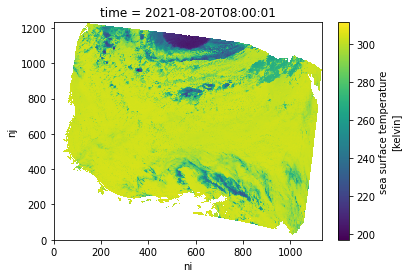

In [32]:
ds.sea_surface_temperature.plot() ;

## Resources

1. In-depth exploration of the `MODIS_A-JPL-L2P-v2019.0` data set, co-locating in-situ and remote sensing data: 
https://github.com/podaac/tutorials/blob/master/notebooks/SWOT-EA-2021/Colocate_satellite_insitu_ocean.ipynb

2. Harmony-Py library introduction tutorial: https://github.com/nasa/harmony-py/blob/main/examples/intro_tutorial.ipynb